# 1. VHM Dataset

In [167]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [168]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
# Remove commas and convert to float
# df1 = df1.str.replace(',', '').astype(float)
df1

0       68421
1       70075
2       68421
3       69022
4       69173
        ...  
1247    43350
1248    44200
1249    44400
1250    43400
1251    43950
Name: Price, Length: 1252, dtype: int64

In [169]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [170]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [171]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [172]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [173]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [174]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [175]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 4s 103ms/step - loss: 0.1061 - val_loss: 0.0589
Epoch 2/100
17/17 [==============================] - 2s 145ms/step - loss: 0.0144 - val_loss: 0.0161
Epoch 3/100
17/17 [==============================] - 2s 138ms/step - loss: 0.0073 - val_loss: 0.0185
Epoch 4/100
17/17 [==============================] - 2s 107ms/step - loss: 0.0044 - val_loss: 0.0096
Epoch 5/100
17/17 [==============================] - 2s 119ms/step - loss: 0.0030 - val_loss: 0.0057
Epoch 6/100
17/17 [==============================] - 2s 105ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/100
17/17 [==============================] - 2s 107ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
17/17 [==============================] - 2s 102ms/step - loss: 0.0013 - val_loss: 8.4934e-04
Epoch 9/100
17/17 [==============================] - 2s 131ms/step - loss: 0.0013 - val_loss: 7.2342e-04
Epoch 10/100
17/17 [==============================] - 2s 145ms/step - loss: 0.0013 

In [176]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 52ms/step


In [177]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [178]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 42903.28641312412
Testing MAPE: 533269.8808840886
Testing MAE: 42883.75430557766


In [179]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

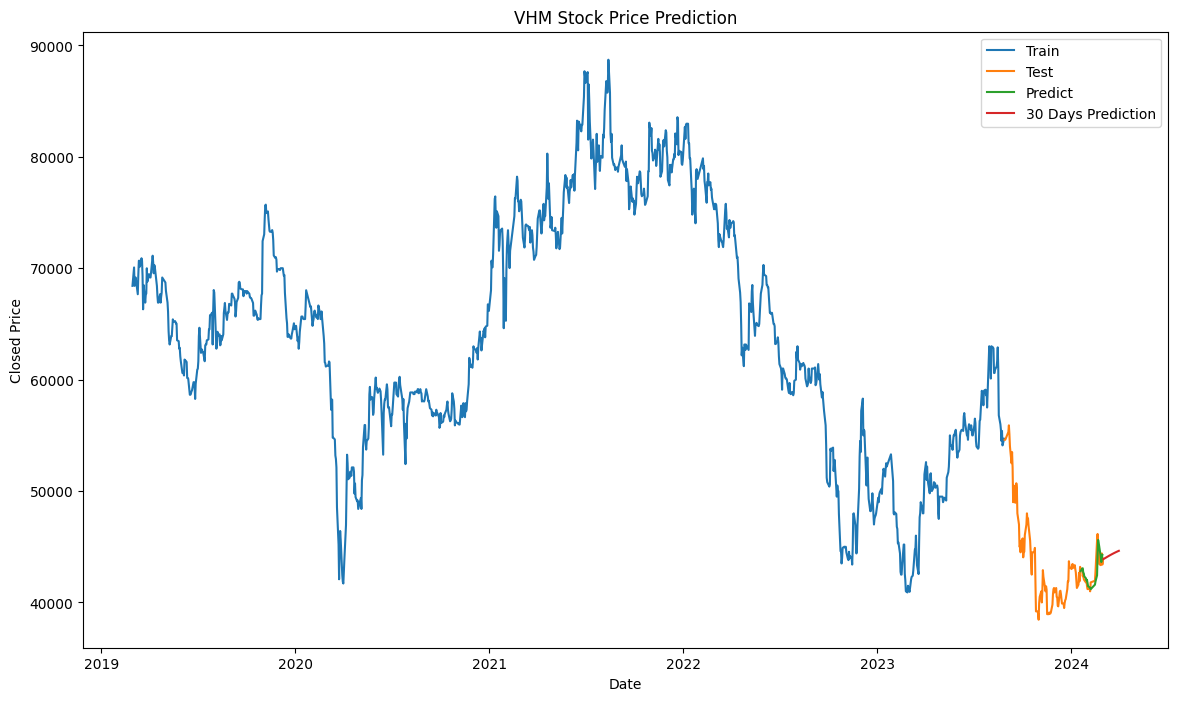

In [180]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [181]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [182]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [183]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [184]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [185]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [186]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 95ms/step - loss: 0.2653 - val_loss: 0.0298
Epoch 2/100
15/15 [==============================] - 1s 57ms/step - loss: 0.0223 - val_loss: 0.0611
Epoch 3/100
15/15 [==============================] - 1s 58ms/step - loss: 0.0119 - val_loss: 0.0275
Epoch 4/100
15/15 [==============================] - 1s 59ms/step - loss: 0.0097 - val_loss: 0.0311
Epoch 5/100
15/15 [==============================] - 1s 85ms/step - loss: 0.0073 - val_loss: 0.0222
Epoch 6/100
15/15 [==============================] - 1s 94ms/step - loss: 0.0056 - val_loss: 0.0160
Epoch 7/100
15/15 [==============================] - 1s 95ms/step - loss: 0.0041 - val_loss: 0.0111
Epoch 8/100
15/15 [==============================] - 1s 58ms/step - loss: 0.0031 - val_loss: 0.0071
Epoch 9/100
15/15 [==============================] - 1s 58ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 10/100
15/15 [==============================] - 1s 57ms/step - loss: 0.0018 - val_loss: 0.0028

In [187]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 14ms/step


In [188]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [189]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 46945.50104405911
Testing MAPE: 1.1839360594788657e+18
Testing MAE: 46434.031793891234


In [190]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

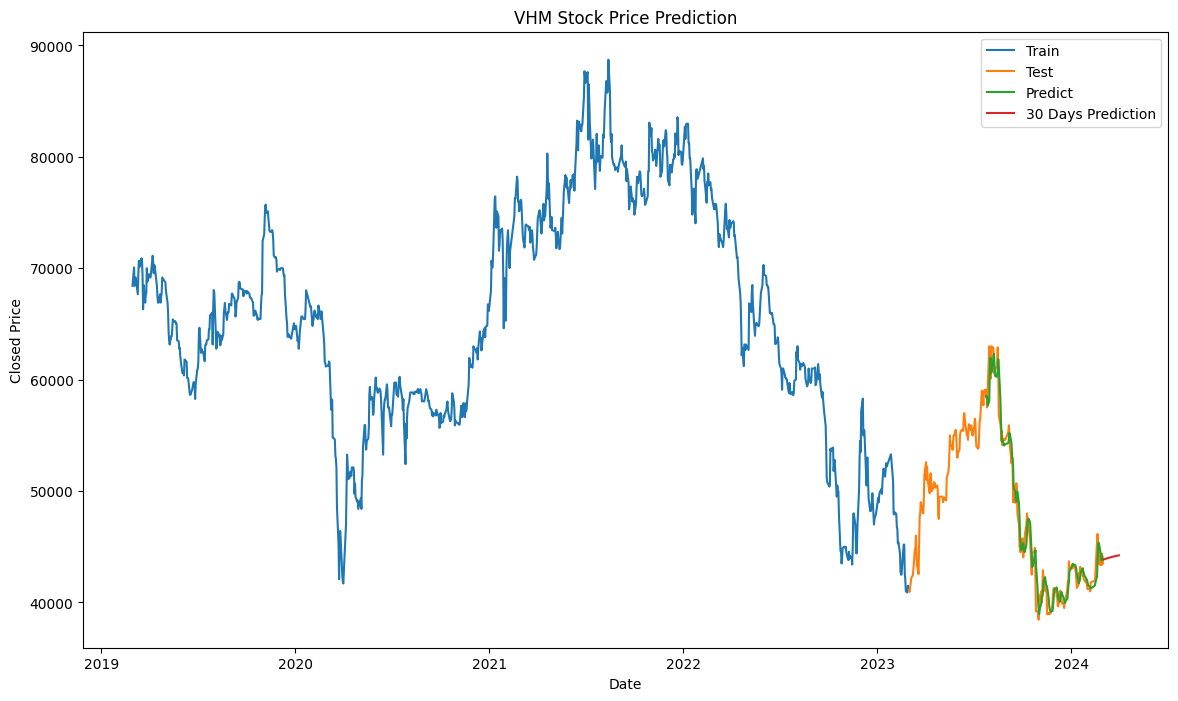

In [191]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [192]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [193]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [194]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [195]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [196]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [197]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 98ms/step - loss: 0.1304 - val_loss: 0.0247
Epoch 2/100
13/13 [==============================] - 1s 90ms/step - loss: 0.0160 - val_loss: 0.0263
Epoch 3/100
13/13 [==============================] - 1s 96ms/step - loss: 0.0054 - val_loss: 0.0113
Epoch 4/100
13/13 [==============================] - 1s 96ms/step - loss: 0.0048 - val_loss: 0.0165
Epoch 5/100
13/13 [==============================] - 1s 68ms/step - loss: 0.0036 - val_loss: 0.0129
Epoch 6/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0030 - val_loss: 0.0100
Epoch 7/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0026 - val_loss: 0.0093
Epoch 8/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 9/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 10/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0017 - val_loss: 0.0044

In [198]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 14ms/step


In [199]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [200]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 49164.599562110714
Testing MAPE: 6.54861704799949e+17
Testing MAE: 48742.93547198694


In [201]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

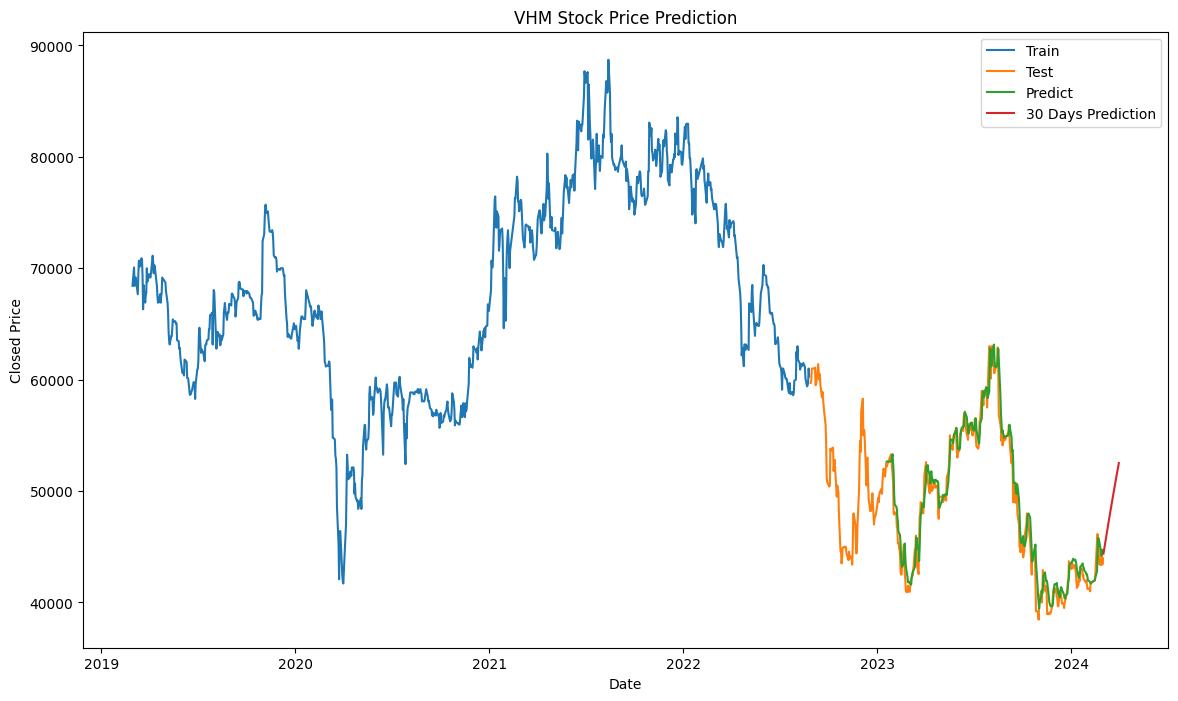

In [202]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

# 2. NVL Dataset

In [203]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [204]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
# Remove commas and convert to float
# df1 = df1.str.replace(',', '').astype(float)
df1

0       32933
1       33100
2       32711
3       31709
4       31932
        ...  
1247    16800
1248    17050
1249    17000
1250    17100
1251    17300
Name: Price, Length: 1252, dtype: int64

In [205]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [206]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [207]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [208]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [209]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [210]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [211]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 4s 86ms/step - loss: 0.0442 - val_loss: 0.0242
Epoch 2/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0068 - val_loss: 0.0022
Epoch 3/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 4/100
17/17 [==============================] - 1s 54ms/step - loss: 6.1009e-04 - val_loss: 1.7933e-05
Epoch 5/100
17/17 [==============================] - 1s 55ms/step - loss: 4.5206e-04 - val_loss: 3.9397e-05
Epoch 6/100
17/17 [==============================] - 1s 53ms/step - loss: 4.2943e-04 - val_loss: 1.7029e-05
Epoch 7/100
17/17 [==============================] - 1s 54ms/step - loss: 4.3448e-04 - val_loss: 1.6170e-05
Epoch 8/100
17/17 [==============================] - 1s 53ms/step - loss: 4.0574e-04 - val_loss: 1.6073e-05
Epoch 9/100
17/17 [==============================] - 1s 83ms/step - loss: 3.8274e-04 - val_loss: 1.6600e-05
Epoch 10/100
17/17 [==============================] 

In [212]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 53ms/step


In [213]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [214]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 16775.86831261489
Testing MAPE: 204778.7432852993
Testing MAE: 16771.291592864818


In [215]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

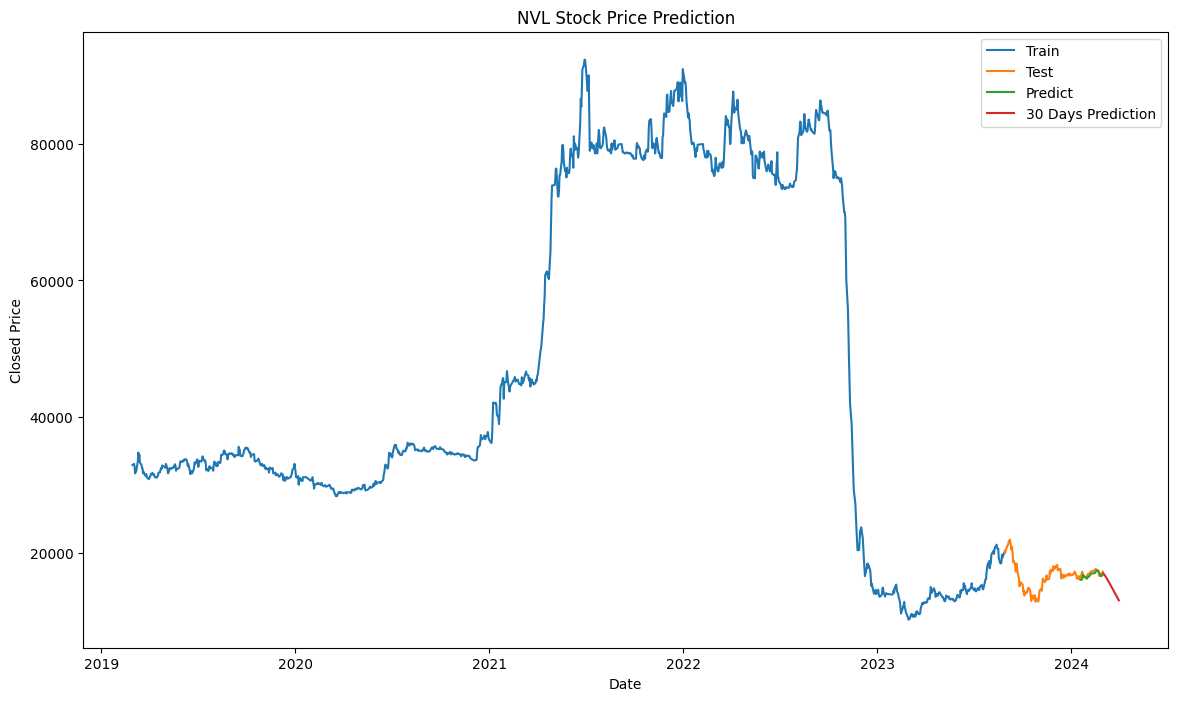

In [216]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [217]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [218]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [219]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [220]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [221]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [222]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 96ms/step - loss: 0.1267 - val_loss: 0.0637
Epoch 2/100
15/15 [==============================] - 1s 60ms/step - loss: 0.0231 - val_loss: 0.0209
Epoch 3/100
15/15 [==============================] - 1s 55ms/step - loss: 0.0099 - val_loss: 0.0146
Epoch 4/100
15/15 [==============================] - 1s 61ms/step - loss: 0.0049 - val_loss: 0.0077
Epoch 5/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/100
15/15 [==============================] - 1s 97ms/step - loss: 0.0011 - val_loss: 6.0718e-04
Epoch 7/100
15/15 [==============================] - 1s 94ms/step - loss: 6.5646e-04 - val_loss: 1.6755e-04
Epoch 8/100
15/15 [==============================] - 1s 77ms/step - loss: 5.8311e-04 - val_loss: 1.0755e-04
Epoch 9/100
15/15 [==============================] - 1s 60ms/step - loss: 5.6839e-04 - val_loss: 1.1029e-04
Epoch 10/100
15/15 [==============================] - 1s 60ms/step - los

In [223]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 14ms/step


In [224]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [225]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 17009.06930023221
Testing MAPE: 217817.14136052833
Testing MAE: 16881.130770746247


In [226]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

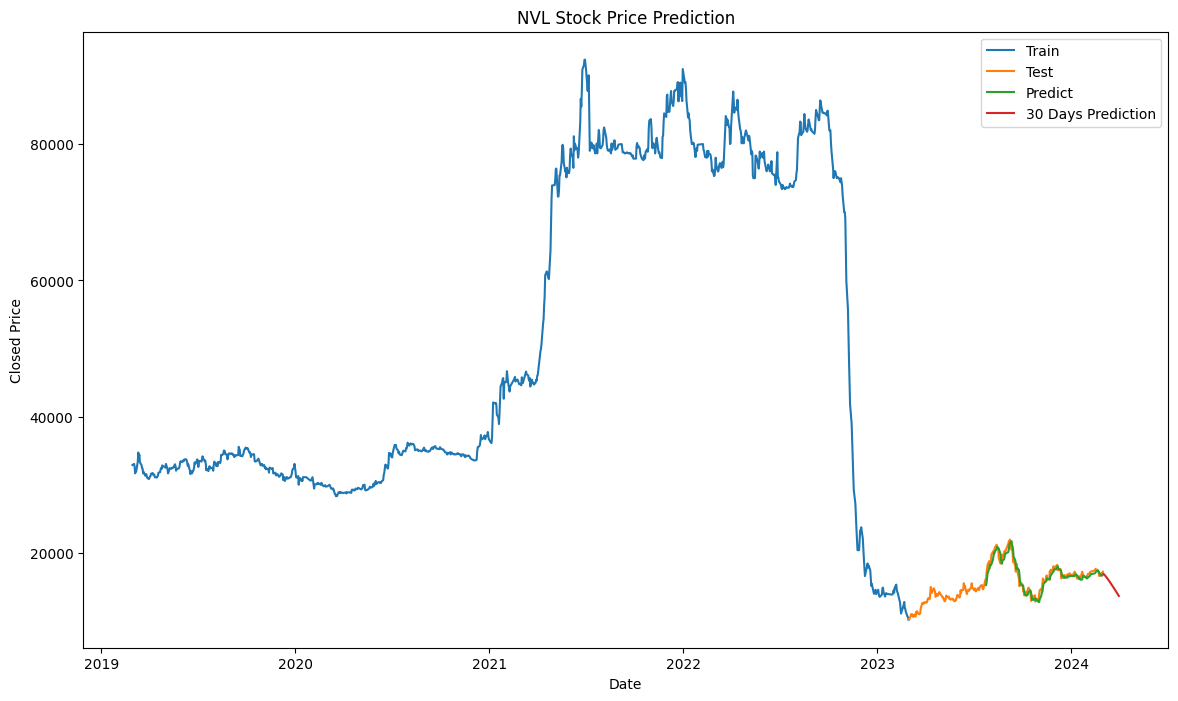

In [227]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [228]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [229]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [230]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [231]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [232]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [233]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 5s 181ms/step - loss: 0.1028 - val_loss: 0.0479
Epoch 2/100
13/13 [==============================] - 1s 78ms/step - loss: 0.0199 - val_loss: 0.0233
Epoch 3/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0087 - val_loss: 0.0138
Epoch 4/100
13/13 [==============================] - 1s 67ms/step - loss: 0.0045 - val_loss: 0.0133
Epoch 5/100
13/13 [==============================] - 1s 67ms/step - loss: 0.0026 - val_loss: 0.0051
Epoch 6/100
13/13 [==============================] - 1s 64ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 7/100
13/13 [==============================] - 1s 69ms/step - loss: 6.6962e-04 - val_loss: 8.2170e-04
Epoch 8/100
13/13 [==============================] - 1s 64ms/step - loss: 4.0261e-04 - val_loss: 2.9654e-04
Epoch 9/100
13/13 [==============================] - 1s 72ms/step - loss: 3.3233e-04 - val_loss: 1.2536e-04
Epoch 10/100
13/13 [==============================] - 1s 63ms/step - loss: 

In [234]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 12ms/step


In [235]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [236]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 15445.10905955505
Testing MAPE: 1.762735282435774e+17
Testing MAE: 15231.504723019665


In [237]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

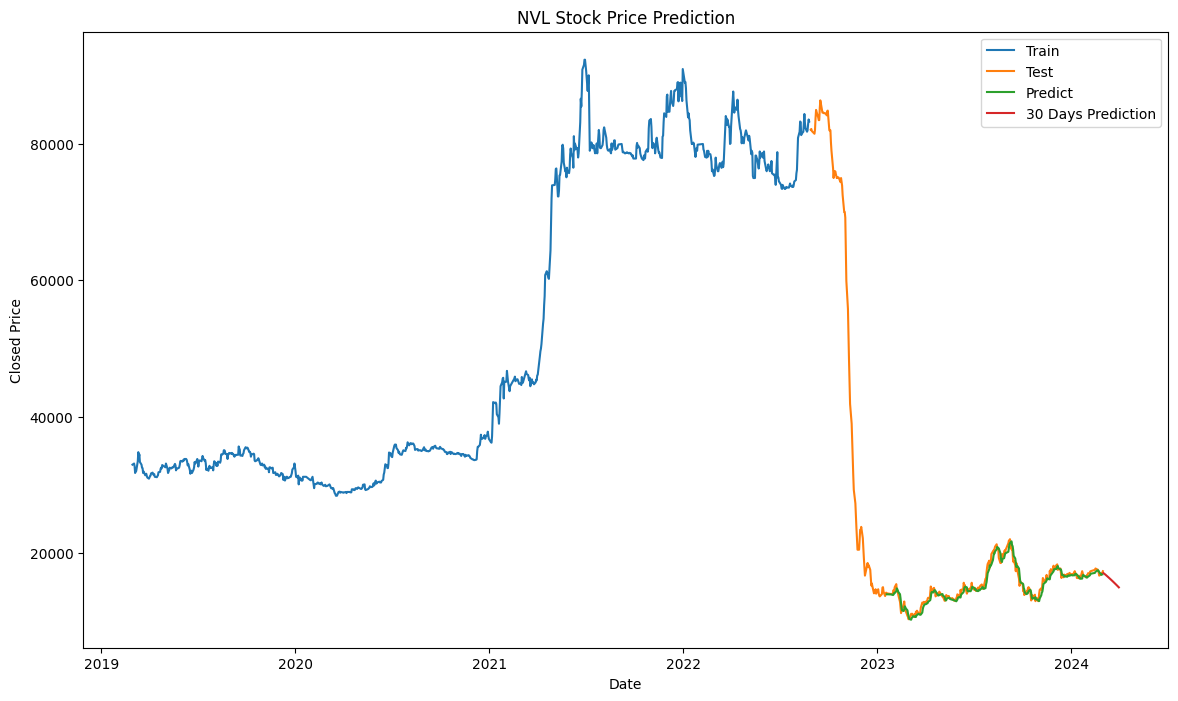

In [238]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

# 3. NLG Dataset

In [239]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [240]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
# Remove commas and convert to float
# df1 = df1.str.replace(',', '').astype(float)
df1

0       18707
1       19127
2       18917
3       18847
4       18707
        ...  
1247    37400
1248    38500
1249    38200
1250    39600
1251    39900
Name: Price, Length: 1252, dtype: int64

In [241]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [242]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [243]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [244]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [245]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [246]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [247]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 93ms/step - loss: 0.0544 - val_loss: 0.0111
Epoch 2/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0132 - val_loss: 0.0078
Epoch 3/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0049 - val_loss: 8.2485e-04
Epoch 4/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/100
17/17 [==============================] - 1s 55ms/step - loss: 9.6950e-04 - val_loss: 2.4910e-04
Epoch 6/100
17/17 [==============================] - 1s 56ms/step - loss: 8.1621e-04 - val_loss: 2.6171e-04
Epoch 7/100
17/17 [==============================] - 1s 57ms/step - loss: 7.9248e-04 - val_loss: 2.4847e-04
Epoch 8/100
17/17 [==============================] - 1s 58ms/step - loss: 8.0859e-04 - val_loss: 2.8983e-04
Epoch 9/100
17/17 [==============================] - 1s 87ms/step - loss: 7.6551e-04 - val_loss: 3.1821e-04
Epoch 10/100
17/17 [==============================] - 2s

In [248]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 35ms/step


In [249]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [250]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 39592.052065892196
Testing MAPE: 79640.88524838314
Testing MAE: 39588.205968386224


In [251]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

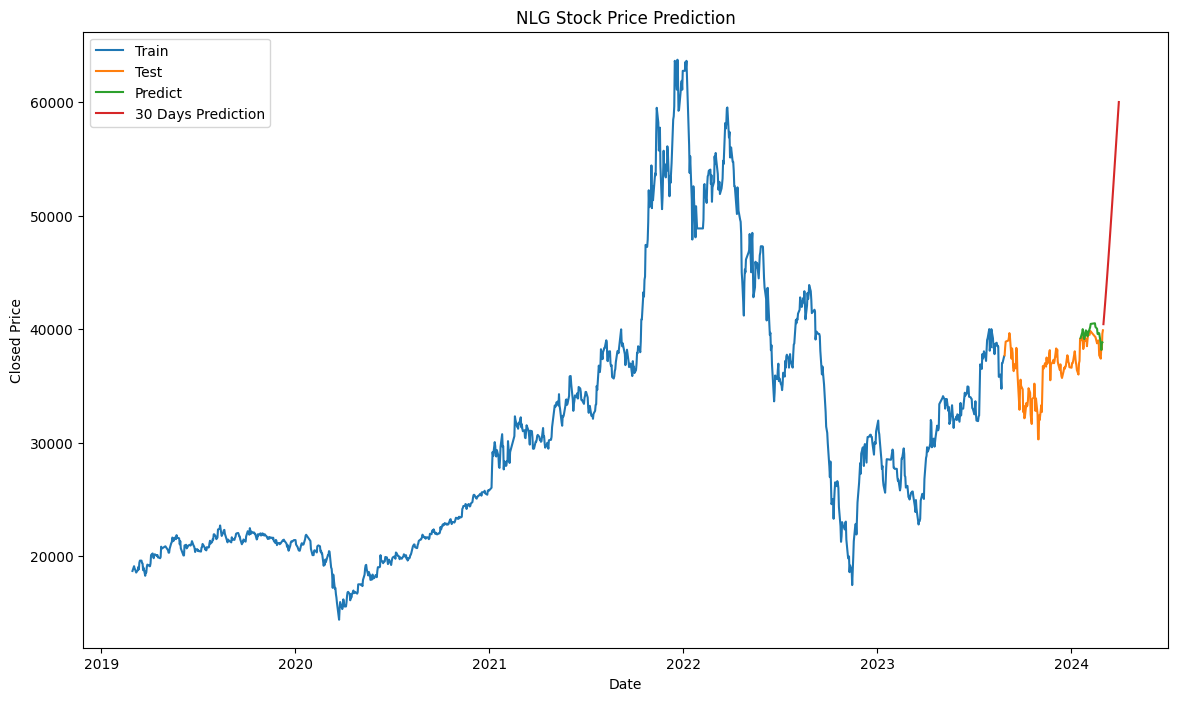

In [252]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [253]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [254]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [255]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [256]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [257]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [258]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 3s 89ms/step - loss: 0.0619 - val_loss: 0.0095
Epoch 2/100
15/15 [==============================] - 1s 55ms/step - loss: 0.0145 - val_loss: 0.0025
Epoch 3/100
15/15 [==============================] - 1s 55ms/step - loss: 0.0051 - val_loss: 6.0470e-04
Epoch 4/100
15/15 [==============================] - 1s 65ms/step - loss: 0.0017 - val_loss: 6.4792e-04
Epoch 5/100
15/15 [==============================] - 1s 87ms/step - loss: 9.2241e-04 - val_loss: 6.0464e-04
Epoch 6/100
15/15 [==============================] - 1s 97ms/step - loss: 8.5389e-04 - val_loss: 6.6741e-04
Epoch 7/100
15/15 [==============================] - 1s 69ms/step - loss: 8.4166e-04 - val_loss: 5.9780e-04
Epoch 8/100
15/15 [==============================] - 1s 57ms/step - loss: 7.8109e-04 - val_loss: 5.7783e-04
Epoch 9/100
15/15 [==============================] - 1s 57ms/step - loss: 7.6601e-04 - val_loss: 6.5330e-04
Epoch 10/100
15/15 [==============================] 

In [259]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 12ms/step


In [260]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [261]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 37025.298522706384
Testing MAPE: 81913.05408592318
Testing MAE: 36961.246108162464


In [262]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

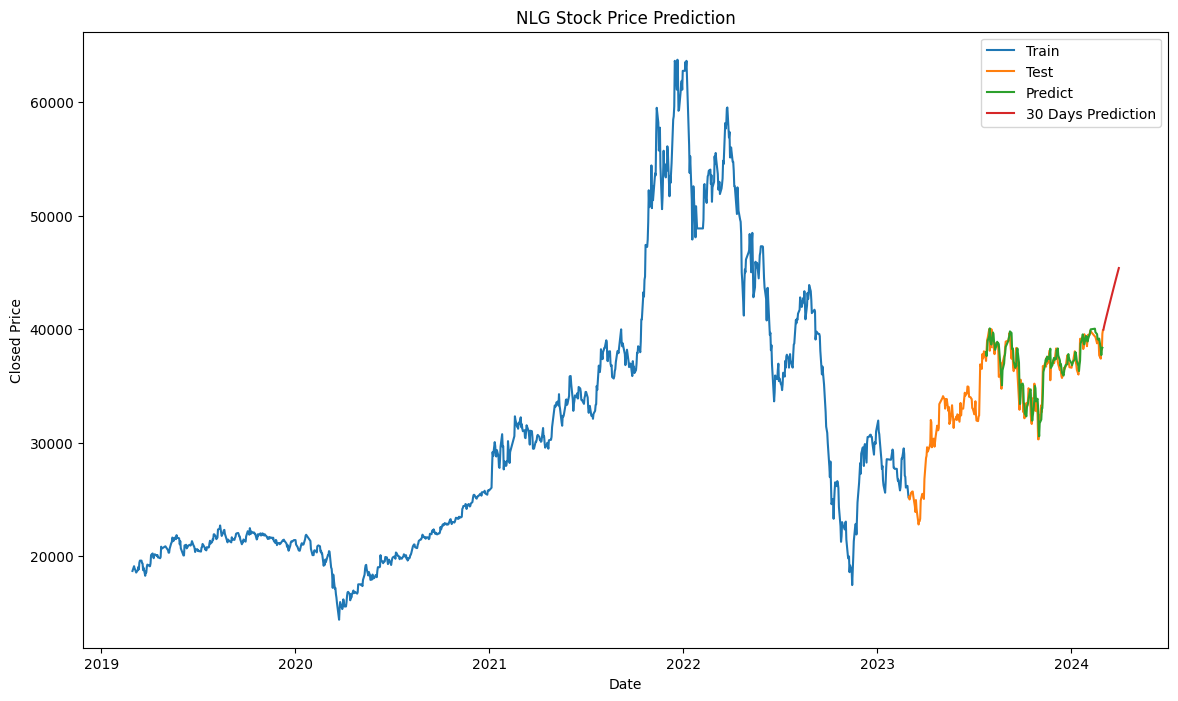

In [263]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [264]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [265]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [266]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [267]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [268]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [269]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 107ms/step - loss: 0.0608 - val_loss: 0.0096
Epoch 2/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0152 - val_loss: 0.0012
Epoch 3/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0050 - val_loss: 7.4283e-04
Epoch 4/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0016 - val_loss: 6.3623e-04
Epoch 5/100
13/13 [==============================] - 1s 60ms/step - loss: 8.4872e-04 - val_loss: 6.8335e-04
Epoch 6/100
13/13 [==============================] - 1s 59ms/step - loss: 8.3511e-04 - val_loss: 6.3909e-04
Epoch 7/100
13/13 [==============================] - 1s 61ms/step - loss: 7.7038e-04 - val_loss: 6.0305e-04
Epoch 8/100
13/13 [==============================] - 1s 85ms/step - loss: 7.3480e-04 - val_loss: 5.9286e-04
Epoch 9/100
13/13 [==============================] - 1s 100ms/step - loss: 7.4113e-04 - val_loss: 5.7669e-04
Epoch 10/100
13/13 [==============================

In [270]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 12ms/step


In [271]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [272]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 33958.09087624398
Testing MAPE: 88162.31508132369
Testing MAE: 33676.42496064072


In [273]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

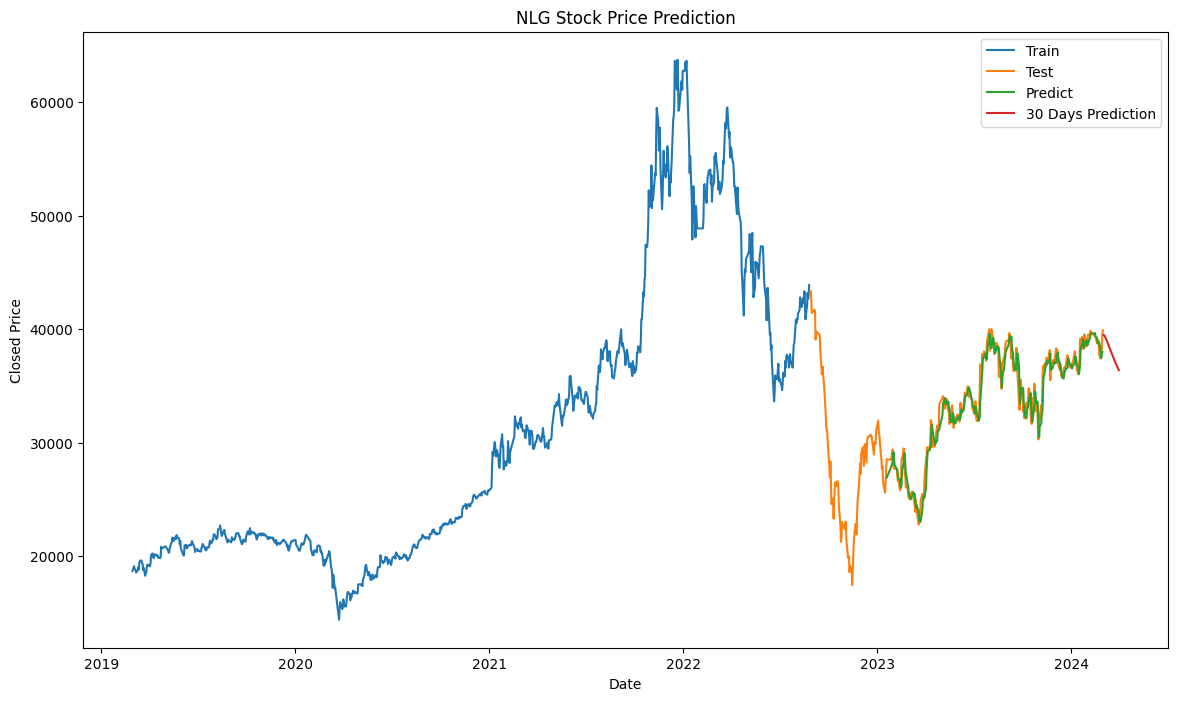

In [274]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()